# Tutorial for `pneumoinfer`

In [1]:
import sys
path = '/Users/Rob/work/pneumoinfer'
sys.path.append(path + '/source/') 
from pneumoinfer import pneumoinfer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Fixed occupation rate

### Basic runs of the simulation and ODE approximation

In [2]:
nstat = 10
pn = pneumoinfer(nstat)

In [3]:
kmu = 1.0
param_dic = {
    'Curr'  : 0,
    'npast' : np.zeros(nstat),
    'Lam'   : np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'mu'    : np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'f'     : np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'eps'   : 1.0/5.0,
    'sig'   : 1.0,
    'mumax' : 1.0
}

#param_dic['vef'] = 0.5*np.ones(nstat)
#param_dic['vt'] = -np.ones(nstat)
#param_dic['vt'][4] = 2.0

In [4]:
pn.create_members(1,param_dic)

In [5]:
nreals = 1000
times = [0.2*float(i) + 0.1 for i in range(0,80)]
pn.run_ode(20.0,0.001)
pn.run_sim(nreals,20.0,0.01,time_snaps=times)

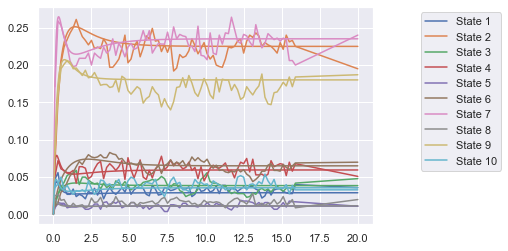

In [6]:
colours = sns.color_palette()
probs = []
for t in times:
    counts = pd.Series(pn.sim_output['Curr'][t].flatten()).value_counts()
    pr = np.zeros(11)
    pr[counts.index.values.astype(int)] = counts.values/float(nreals)
    probs.append(list(pr))
for i in range(0,10):
    plt.plot(times,np.asarray(probs)[:,i+1],label='State '+str(i+1),color=colours[i])
    plt.plot(pn.ode_output['time'],pn.ode_output['probCurr'][:,i],color=colours[i])
plt.legend(bbox_to_anchor=(1.4,1.0))
plt.show()

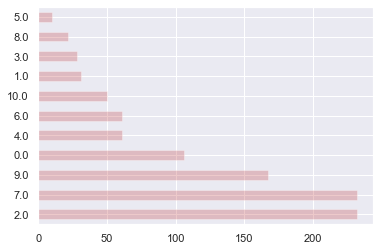

In [7]:
t = times[60]
pd.Series(pn.sim_output['Curr'][t].flatten()).value_counts().plot.barh(color='r',alpha=0.3)
plt.show()

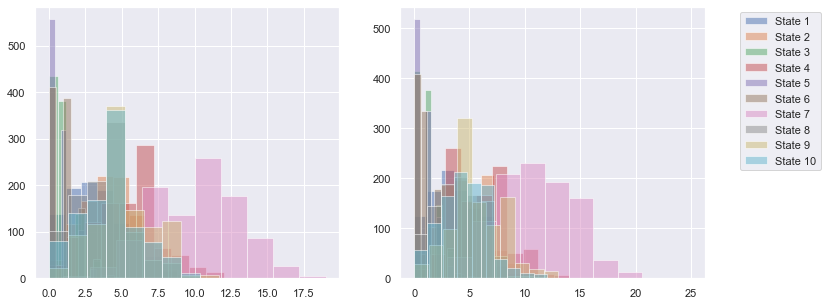

In [8]:
t = times[60]
it = np.argmin((pn.ode_output['time']-t)**2)
fig, axs = plt.subplots(1,2,figsize=(12,5))
for nps, Enps, i in zip(
    pn.sim_output['npastsum'][t],
    pn.ode_output['Expnpast'][it],
    range(0,10)
): 
    axs[0].hist(nps,label='State '+ str(i+1),alpha=0.5)
    axs[1].hist(np.random.poisson(Enps,size=nreals),label='State '+ str(i+1),alpha=0.5)
axs[1].legend(bbox_to_anchor=(1.4,1.0))
plt.show()

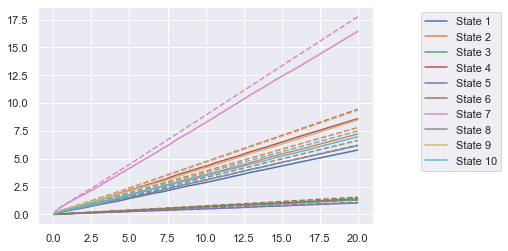

In [9]:
colours = sns.color_palette()
ncounts = []
for t in times:
    nco = np.sum(pn.sim_output['npastsum'][t],axis=1)
    ncounts.append(nco/nreals)
for i in range(0,nstat):
    plt.plot(times,np.asarray(ncounts)[:,i],label='State ' + str(i+1),color=colours[i])
    plt.plot(pn.ode_output['time'],pn.ode_output['Expnpast'][:,i],'--',color=colours[i])
plt.legend(bbox_to_anchor=(1.4,1.0))
plt.show()

### Fitting to data

In [10]:
# Create some mock state observation data out of the simulation runs above
data_times = np.random.choice(times, 10, replace=False)
df = pd.Series(pn.sim_output['Curr'][data_times[0]].flatten()).value_counts().reset_index()
df['Time'] = data_times[0]
for t in data_times[1:]:
    new_df = pd.Series(pn.sim_output['Curr'][t].flatten()).value_counts().reset_index()
    new_df['Time'] = t
    df = pd.concat([df, new_df], ignore_index=True)
df = df.rename(columns={'index' : 'Curr', 0 : 'Count'})
df.Curr = df.Curr.astype(int)
df

,Curr,Count,Time
0,2,239,13.5
1,7,237,13.5
2,9,172,13.5
3,0,110,13.5
4,4,53,13.5
...,...,...,...
105,1,35,11.9
106,10,33,11.9
107,3,30,11.9
108,8,21,11.9


In [11]:
nstat = 10
pn = pneumoinfer(nstat)
pn.create_members(1,param_dic,data=df)

In [12]:
pn.lnlike_and_grad(0.001)

(-20435.85411236761,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

## Varying occupation rate

In [13]:
nstat = 10
pn = pneumoinfer(nstat)

In [14]:
kmu = 1.0
param_dic = {
    'npast' : np.zeros(nstat),
    'Lam'   : np.zeros(nstat),#np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'mu'    : np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'f'     : np.random.gamma(kmu,1.0/kmu,size=nstat),#np.ones(nstat),
    'eps'   : 1.0/5.0,
    'sig'   : 1.0,
    'mumax' : 1.0,
}

#param_dic['vef'] = 0.5*np.ones(nstat)
#param_dic['vt'] = -np.ones(nstat)
#param_dic['vt'][4] = 2.0

In [15]:
pn._cont_mat = np.ones((3,3))

In [16]:
nind = 1000
for i in range(0,nind):
    group_param_dic = param_dic.copy()
    group_param_dic['Curr'] = np.random.randint(0,nstat+1)
    group_param_dic['cind'] = np.random.randint(0,3)
    pn.create_members(1,group_param_dic)

In [17]:
nreals = 1
times = [0.2*float(i) + 0.1 for i in range(0,80)]
pn.run_ode(20.0,0.001)
pn.run_sim(nreals,20.0,0.01,time_snaps=times)

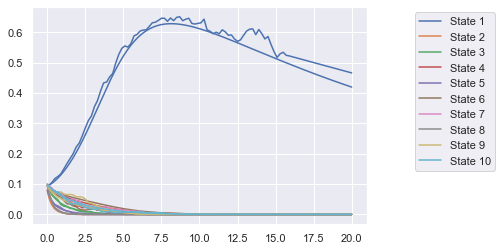

In [18]:
colours = sns.color_palette()
probs = []
for t in times:
    counts = pd.Series(pn.sim_output['Curr'][t].flatten()).value_counts()
    pr = np.zeros(11) 
    pr[counts.index.values.astype(int)] = counts.values/float(nreals)
    probs.append(list(pr))
for i in range(0,10):
    plt.plot(times,np.asarray(probs)[:,i+1]/float(nind),label='State '+str(i+1),color=colours[i])
    plt.plot(pn.ode_output['time'],pn.ode_output['probCurr'][:,i],color=colours[i])
plt.legend(bbox_to_anchor=(1.4,1.0))
plt.show()